# Using `ipyparallel`

Parallel execution is tightly integrated with Jupyter in the `ipyparallel` package. Install with

```bash
pip install ipyparallel
```

This is a rich framework. For more on how to use `ipyparallel`, see

[Official documentation](https://ipyparallel.readthedocs.org/en/latest/)

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## Starting engines

We will only use engines on local cores which does not require any setup - see [docs](https://ipyparallel.readthedocs.org/en/latest/process.html) for detailed instructions on how to set up a remote cluster, including setting up to use Amazon EC2 clusters.

You can start a cluster on the `IPython Clusters` tab in the main Jupyter browser window 

The main advantage of developing parallel applications using `ipyparallel` is that it can be done interactively within Jupyter.

## Basic concepts of `ipyparallel`

In [2]:
from ipyparallel import Client

The client connects to the cluster of "remote" engines that perfrom the actual computation. These engines may be on the same machine or on a cluster. 

In [3]:
rc = Client()

In [4]:
rc.ids

[0, 1, 2, 3, 4, 5, 6, 7]

A view provides access to a subset of the engines available to the client. Jobs are submitted to the engines via the view. A direct view allows the user to explicitly send work specific engines. The load balanced view is like the `Pool` object in `multiprocessing`, and manages the scheduling and distribution of jobs for you.

**Direct view**

In [5]:
dv = rc[:]

Add 10 sets of 3 numbers in parallel using all engines.

In [6]:
dv.map_sync(lambda x, y, z: x + y + z, range(10), range(10), range(10))

[0, 3, 6, 9, 12, 15, 18, 21, 24, 27]

Add 10 sets of 3 numbers in parallel using only alternate engines.

In [7]:
rc[::2].map_sync(lambda x, y, z: x + y + z, range(10), range(10), range(10))

[0, 3, 6, 9, 12, 15, 18, 21, 24, 27]

Add 10 sets of 3 numbers using a specific engine.

In [8]:
rc[2].map_sync(lambda x, y, z: x + y + z, range(10), range(10), range(10))

[0, 3, 6, 9, 12, 15, 18, 21, 24, 27]

**Load balanced view**

Use this when you have many jobs that take different amounts of time to complete.

In [9]:
lv = rc.load_balanced_view()

In [10]:
lv.map_sync(lambda x: sum(x), np.random.random((10, 100000)))

[49981.15094681111,
 49960.0120441638,
 49890.77961950656,
 49918.427545315106,
 50009.64737591964,
 49959.012023061194,
 50060.41833565818,
 49891.862160926394,
 49932.78181816447,
 50113.55074503267]

#### Calling functions with apply

In contrast to `map`, `apply` is just a simple function call run on all remote engines, and has the usual function signature `apply(f, *args, **kwargs)`. It is a primitive on which other more useful functions (such as `map`) are built upon.

In [11]:
rc[1:3].apply_sync(lambda x, y: x**2 + y**2, 3, 4)

[25, 25]

In [12]:
rc[1:3].apply_sync(lambda x, y: x**2 + y**2, x=3, y=4)

[25, 25]

### Synchronous and asynchronous jobs

We have used the `map_sync` and `apply_sync` methods. The `sync` suffix indicate that we want to run a synchronous job. Synchronous jobs `block` until all the computation is done and return the result.

In [13]:
res = dv.map_sync(lambda x, y, z: x + y + z, range(10), range(10), range(10))

In [14]:
res

[0, 3, 6, 9, 12, 15, 18, 21, 24, 27]

In contrast, asynchronous jobs return immediately so that you can do other work, but returns a `AsyncMapResult` object, similar to the `future` object returned by the `concurrent.futures` package. You can query its status, cancel running jobs and retrieve results once they have been computed.

In [15]:
res = dv.map_async(lambda x, y, z: x + y + z, range(10), range(10), range(10))

In [16]:
res

<AsyncMapResult: <lambda>>

In [17]:
res.done()

True

In [18]:
res.get()

[0, 3, 6, 9, 12, 15, 18, 21, 24, 27]

There is also a `map` method that by default uses asynchronous mode, but you can change this by setting the `block` attribute or function argument.

In [19]:
res = dv.map(lambda x, y, z: x + y + z, range(10), range(10), range(10))

In [20]:
res.get()

[0, 3, 6, 9, 12, 15, 18, 21, 24, 27]

Change blocking mode for just one job.

In [21]:
res = dv.map(lambda x, y, z: x + y + z, range(10), range(10), range(10), block=True)

In [22]:
res

[0, 3, 6, 9, 12, 15, 18, 21, 24, 27]

Change blocking mode for this view so that all jobs are synchronous.

In [23]:
dv.block = True

In [24]:
res = dv.map(lambda x, y, z: x + y + z, range(10), range(10), range(10))

In [25]:
res

[0, 3, 6, 9, 12, 15, 18, 21, 24, 27]


### Remote function decorators 

The `@remote` decorator results in functions that will execute simultaneously on all engines in a view. For example, you can use this decorator if you always want to run $n$ independent parallel MCMC chains.

In [26]:
with dv.sync_imports():
    import numpy

importing numpy on engine(s)


In [27]:
@dv.remote(block = True)
def f1(n):
    return numpy.random.rand(n)

In [28]:
f1(4)

[array([0.18472276, 0.58311062, 0.00970686, 0.82963292]),
 array([0.3707495 , 0.55731368, 0.28422286, 0.11945056]),
 array([0.76889473, 0.16928617, 0.87105353, 0.69520204]),
 array([0.77968322, 0.09836705, 0.29899082, 0.43869955]),
 array([0.44118982, 0.22560375, 0.79489356, 0.78417991]),
 array([0.40955816, 0.31819581, 0.45670871, 0.54122942]),
 array([0.55517265, 0.52965973, 0.12639326, 0.61261257]),
 array([0.07980547, 0.47902453, 0.42447179, 0.41533817])]

The @parallel decorator breaks up elementwise operations and distributes them.

In [29]:
@dv.parallel(block = True)
def f2(x):
    return x

In [30]:
f2(range(15))

[range(0, 2),
 range(2, 4),
 range(4, 6),
 range(6, 8),
 range(8, 10),
 range(10, 12),
 range(12, 14),
 range(14, 15)]

In [31]:
@dv.parallel(block = True)
def f3(x):
    return sum(x)

In [32]:
f3(range(15))

[1, 5, 9, 13, 17, 21, 25, 14]

In [33]:
@dv.parallel(block = True)
def f4(x, y):
    return x + y

In [34]:
f4(np.arange(10), np.arange(10))

array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18])

####  Example: Use the `@parallel` decorator to speed up Mandelbrot calculations

In [35]:
def mandel1(x, y, max_iters=80):
    c = complex(x, y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if z.real*z.real + z.imag*z.imag >= 4:
            return i
    return max_iters

In [36]:
@dv.parallel(block = True)
def mandel2(x, y, max_iters=80):
    c = complex(x, y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if z.real*z.real + z.imag*z.imag >= 4:
            return i
    return max_iters

In [37]:
x = np.arange(-2, 1, 0.01)
y = np.arange(-1, 1, 0.01)
X, Y = np.meshgrid(x, y)

In [38]:
%%time
im1 = np.reshape(list(map(mandel1, X.ravel(), Y.ravel())), (len(y), len(x)))

CPU times: user 500 ms, sys: 0 ns, total: 500 ms
Wall time: 500 ms


In [39]:
%%time
im2 = np.reshape(mandel2.map(X.ravel(), Y.ravel()),  (len(y), len(x)))

CPU times: user 32 ms, sys: 8 ms, total: 40 ms
Wall time: 142 ms


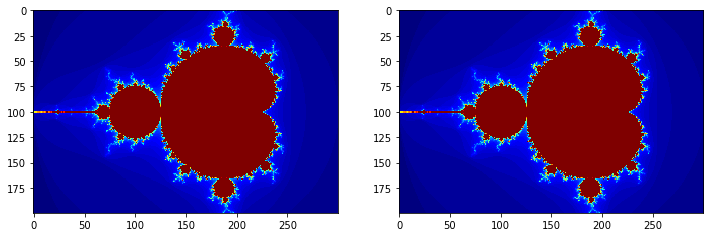

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].grid(False)
axes[0].imshow(im1, cmap='jet')
axes[1].grid(False)
axes[1].imshow(im2, cmap='jet')
pass

### Functions with dependencies

Modules imported locally are NOT available in the remote engines.

In [41]:
import time
import datetime

In [42]:
def g1(x):
    time.sleep(0.1)
    now = datetime.datetime.now()
    return (now, x)

This fails with an Exception because the `time` and `datetime` modules are not imported in the remote engines.

```python
dv.map_sync(g1, range(10))
```

The simplest fix is to import the module(s) *within* the function

In [43]:
def g2(x):
    import time, datetime
    time.sleep(0.1)
    now = datetime.datetime.now()
    return (now, x)

In [44]:
dv.map_sync(g2, range(5))

[(datetime.datetime(2020, 4, 16, 18, 59, 0, 905717), 0),
 (datetime.datetime(2020, 4, 16, 18, 59, 0, 905823), 1),
 (datetime.datetime(2020, 4, 16, 18, 59, 0, 905938), 2),
 (datetime.datetime(2020, 4, 16, 18, 59, 0, 905981), 3),
 (datetime.datetime(2020, 4, 16, 18, 59, 0, 905971), 4)]

Alternatively, you can simultaneously import both locally and in the remote engines with the `sync_import` context manager.

In [45]:
with dv.sync_imports():
    import time
    import datetime

importing time on engine(s)
importing datetime on engine(s)


Now the `g1` function will work.

In [46]:
dv.map_sync(g1, range(5))

[(datetime.datetime(2020, 4, 16, 18, 59, 1, 76582), 0),
 (datetime.datetime(2020, 4, 16, 18, 59, 1, 76747), 1),
 (datetime.datetime(2020, 4, 16, 18, 59, 1, 76795), 2),
 (datetime.datetime(2020, 4, 16, 18, 59, 1, 77072), 3),
 (datetime.datetime(2020, 4, 16, 18, 59, 1, 77054), 4)]

Finally, there is also a `require` decorator that can be used. This will force the remote engine to import all packages given.

In [47]:
from ipyparallel import require

In [48]:
@require('scipy.stats')
def g3(x):
    return scipy.stats.norm(0,1).pdf(x)

In [49]:
dv.map(g3, np.arange(-3, 4))

[0.0044318484119380075,
 0.05399096651318806,
 0.24197072451914337,
 0.3989422804014327,
 0.24197072451914337,
 0.05399096651318806,
 0.0044318484119380075]

### Moving data around

We can send data to remote engines with `push` and retrieve them with `pull`, or using the dictionary interface. For example, you can use this to distribute a large lookup table to all engines once instead of repeatedly as a function argument.

In [50]:
dv.push(dict(a=3, b=2))

[None, None, None, None, None, None, None, None]

In [51]:
def f(x):
    global a, b
    return a*x + b

In [52]:
dv.map_sync(f, range(5))

[2, 5, 8, 11, 14]

In [53]:
dv.pull(('a', 'b'))

[[3, 2], [3, 2], [3, 2], [3, 2], [3, 2], [3, 2], [3, 2], [3, 2]]

#### You can also use the dictionary interface as an alternative to push and pull

In [54]:
dv['c'] = 5

In [55]:
dv['a']

[3, 3, 3, 3, 3, 3, 3, 3]

In [56]:
dv['c']

[5, 5, 5, 5, 5, 5, 5, 5]

Using parallel magic commands
----

In practice, most users will simply use the `%px` magic to execute code in parallel from within the notebook. This is the simplest way to use `ipyparallel`.

In [57]:
def f(xs):
    s = 0
    for x in xs:
        s += x
    return s

In [58]:
dv.map(f, np.random.random((6, 4)))

[1.455821873914668,
 2.5548527878771496,
 1.943134943296887,
 3.5219170200603296,
 3.5108098284842204,
 1.8450153390831912]

### %px

This sends the command to all targeted engines.

In [59]:
%px import numpy as np
%px a = np.random.random(4)
%px a.sum()

Out[0:3]: 1.231755492630267

Out[1:3]: 2.6964804654703194

Out[2:3]: 2.7872819711433436

Out[3:3]: 2.2651690765222607

Out[4:3]: 2.538202038021672

Out[5:3]: 2.342684993836116

Out[6:3]: 1.2899226452213557

Out[7:3]: 1.402290461197728

#### List comprehensions in parallel

The `scatter` method partitions and distributes data to all engines. The `gather` method does the reverse. Together with `%px`, we can simulate parallel list comprehensions.

In [60]:
dv.scatter('a', np.random.randint(0, 10, 10))
%px print(a)

[stdout:0] [9 7]
[stdout:1] [0 9]
[stdout:2] [3]
[stdout:3] [2]
[stdout:4] [9]
[stdout:5] [9]
[stdout:6] [8]
[stdout:7] [5]


In [61]:
dv.gather('a')

array([9, 7, 0, 9, 3, 2, 9, 9, 8, 5])

In [62]:
dv.scatter('xs', range(24))
%px y = [x**2 for x in xs]
np.array(dv.gather('y'))

array([  0,   1,   4,   9,  16,  25,  36,  49,  64,  81, 100, 121, 144,
       169, 196, 225, 256, 289, 324, 361, 400, 441, 484, 529])

#### Running magic functions in parallel

[output:1]

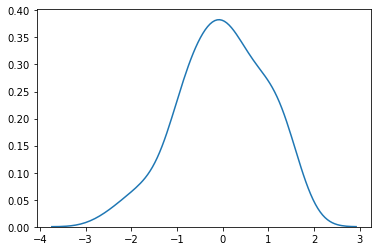

[output:3]

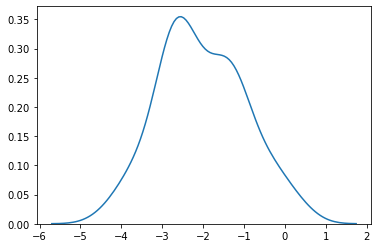

In [63]:
%%px --target [1,3]
%matplotlib inline
import seaborn as sns
x = np.random.normal(np.random.randint(-10, 10), 1, 100)
sns.kdeplot(x);

### Running in non-blocking mode

In [64]:
%%px --target [1,3] --noblock
%matplotlib inline
import seaborn as sns
x = np.random.normal(np.random.randint(-10, 10), 1, 100)
sns.kdeplot(x);

<AsyncResult: execute>

[output:1]

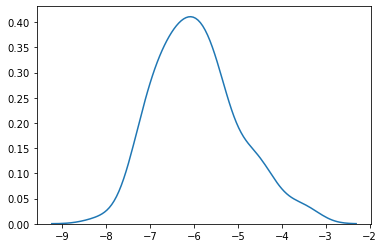

[output:3]

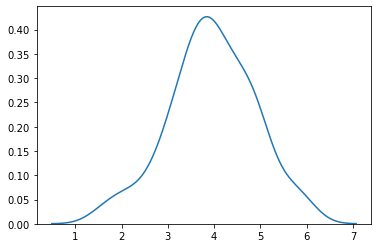

In [65]:
%pxresult